**Step 1**: Install Spark

# New Section

In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# New Section

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [4]:
# install findspark using pip
!pip install -q findspark

In [5]:
!pip3 install pyspark==3.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 18.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805900 sha256=91163d212a6ba340088d7f0c5a90b5c93506dfa3fc9989a173c48e1e29da6aaa
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [6]:
import findspark
findspark.init()

In [7]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [8]:
# Create spark_session
spark_session = SparkSession.builder.getOrCreate()

In [9]:
sc = spark_session.sparkContext

**Setting up Spark**:

Before you can connect to a Spark cluster, Spark needs to be installed. The code below is boilerplate code that can be used to set-up Spark. Please note that this code will be leveraged in all the notebooks since each nodebook is a separate entity.

List the contents of Google Drive

In [10]:
# After executing the cell above, Drive
# files will be present in "/content/My Drive".
!ls "/content/drive/My Drive"

'2022冬季1班 LaiData 第一节课 试听课 12月05日 7PM (美西时间).gdoc'
'Authorization Code.docx'
'Colab Notebooks'
 Documents
 Others
 zhangyu027_token_2023.rtf


**Research Purpose**

Customer segmentation is a marketing tool to group your customers based on common characteristics so that you can focus and market to each group effectively and maximize the value of each customer to the business.

Like so many other disciplines, in business as well, we see that old 80–20 rule. Where 80% of your revenue comes from 20% of your customers. That’s why to increase your business you need to understand your customer.

There are at least two main goals of customer segmentation:

Continue to provide the best service to your best customers.
Focus on prospective customers who resemble your best customers.

```
# This is formatted as code
```



# Table of content
 - RFM Model
 - Dataset
 - Recency, Frequency & Monetary value calculation
 -  RFM score calculation
 -  Segmentation based on RFM Score
 -  Segmentation results
 -  Conclusion

Recency, Frequency & Monetary value calculation
The first thing we’ll calculate is the three key factors of RFM Analysis (recency, frequency, and monetary).

* Recency: How recently customers made their purchase.
* Frequency: For simplicity, we’ll count the number of times each * customer made a purchase.
* Monetary: How much money they spent in total.


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import to_date
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("PySpark").getOrCreate()
spark

In [23]:
def printdf(df, l=5):
    return df.limit(l).toPandas()

def nullcount(df):
    return {col: df.filter(df[col].isNull()).count() for col in df.columns}

def shape(df):
    # df.toPandas().shape
    print((df.count(), len(df.columns)))

In [24]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
data = spark.read.csv("/content/drive/My Drive/Colab Notebooks/datasets/OnlineRetail.csv", 
                      inferSchema=True, 
                      header=True)
data1 = data.withColumn("OrderDate", to_date(col("InvoiceDate"), "MM/dd/yyyy"))
print('Dataframe dimensions:', (data1.count(), len(data1.columns)))
printdf(data1)

Dataframe dimensions: (112661, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,OrderDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01


# EDA

In [25]:
# Check the shape (number of columns and rows) in the dataset

# data.toPandas().shape
data.toPandas().describe()

,UnitPrice
count,112657.000000
mean,5.487091
std,126.337686
min,0.000000
25%,1.250000
50%,2.250000
75%,4.210000
max,16888.020000


In [26]:
nullcount(data)

{'InvoiceNo': 0,
 'StockCode': 0,
 'Description': 468,
 'Quantity': 1,
 'InvoiceDate': 2,
 'UnitPrice': 4,
 'CustomerID': 35608,
 'Country': 5}

In [27]:
# Customer distribution by country

rtl_data = data["Country", "CustomerID"].distinct()\
    .groupBy("Country")\
    .agg(F.count("CustomerID").alias("Count"))\
    .withColumn('Total', F.sum('Count').over(Window.partitionBy()))\
    .withColumn('%', (F.col('Count')/F.col('Total'))*100)\
    .sort("Count", ascending=False)

printdf(rtl_data)

,Country,Count,Total,%
0,United Kingdom,1767,1942,90.988671
1,Germany,42,1942,2.162719
2,France,37,1942,1.905252
3,Spain,12,1942,0.617920
4,Portugal,10,1942,0.514933


In [28]:
rtl_data

DataFrame[Country: string, Count: bigint, Total: bigint, %: double]

#### Looks like 90% of the customers are from UK So, from now on we'll consider only UK's customers

In [29]:
# Consider only customers from UK
rtl_data = data.filter(F.col("Country") == "United Kingdom")

# Filter out null customer ids
rtl_data = rtl_data.filter(F.col("CustomerID").isNotNull())

rtl_data.toPandas().shape

printdf(rtl_data)
# rtl_data.toPandas().describe()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [30]:
# Other approach to check null counts
nullcount(rtl_data)

{'InvoiceNo': 0,
 'StockCode': 0,
 'Description': 0,
 'Quantity': 0,
 'InvoiceDate': 0,
 'UnitPrice': 0,
 'CustomerID': 0,
 'Country': 0}

In [31]:
# Explore the schema of the dataframe
# rtl_data.printSchema()

In [32]:
# See basic stats of numeric columns
rtl_data.toPandas().describe()

,UnitPrice
count,69370.000000
mean,3.142187
std,11.534781
min,0.000000
25%,1.250000
50%,1.950000
75%,3.750000
max,1867.860000


In [33]:
# Remove negative Quantities
rtl_data = rtl_data.filter(F.col("Quantity") > 0)

# Introduce Total Amount column
rtl_data = rtl_data.withColumn("TotalAmount", F.round(F.col("Quantity") * F.col("UnitPrice")))

# Reformat invoice date to yyyy-MM-dd
rtl_data = rtl_data.withColumn("InvoiceDate", 
                               F.to_date(F.col("InvoiceDate"), 'MM/dd/yyyy'))
# rtl_data = rtl_data.withColumn("InvoiceDate", F.from_unixtime(F.unix_timestamp(F.col("InvoiceDate"), 'MM/dd/yyyy')))

printdf(rtl_data)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,20.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,20.0


In [34]:
# Max and Min Date

df = rtl_data.toPandas()

print(df.InvoiceDate.min())
print(df.InvoiceDate.max())

2010-12-01
2011-04-19


# RFM Modeling

In [35]:
rtl_data.select(F.max('InvoiceDate')).collect()

[Row(max(InvoiceDate)=datetime.date(2011, 4, 19))]

In [36]:
# Recency   = Overall latest invoice date - individual customer's last invoice date
# Frequency = count of invoice no. of transaction(s)
# Monetary = Sum of Total amount for each customer

# Set 2011/12/10 as the overall last invoice date. This is to calculate recency in days.
latest_date = F.to_date(F.lit("2011/12/10"), 'yyyy/MM/dd')

# Create RFM Modelling scores for each customer

### Approach One
rfm_scores = (rtl_data.groupBy("CustomerID")
              .agg((F.datediff(latest_date, F.max(F.col("InvoiceDate")))).alias("Recency"),
                   F.count("*").alias("Frequency"),
                   F.sum(F.col("TotalAmount")).alias("Monetary")).sort("CustomerID"))

### Approach Two
# recency = (
#     rtl_data.groupBy("CustomerID")
#             .agg((F.datediff(latest_date, F.max(F.col("InvoiceDate")))).alias("Recency"))
# )

# frequency = (
#     rtl_data.groupBy("CustomerID", "InvoiceNo").count()
#             .groupBy("CustomerID")
#             .agg(F.count("*").alias("Frequency"))
# )

# monetary = (
#     rtl_data.groupBy("CustomerID")
#             .agg(F.sum(F.col("TotalAmount")).alias("Monetary"))
# )

# rfm_scores = (
#     recency.join(frequency, 'CustomerID', how = 'inner')
#            .join(monetary,'CustomerID', how = 'inner')
# )

printdf(rfm_scores)

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77184.0
1,12747,362,15,709.0
2,12748,237,982,6586.0
3,12820,327,11,172.0
4,12823,255,1,459.0


In [37]:
rfm_scores

DataFrame[CustomerID: string, Recency: int, Frequency: bigint, Monetary: double]

In [38]:
rfm_scores.toPandas().describe()

,Recency,Frequency,Monetary
count,1707.000000,1707.000000,1707.000000
mean,286.728764,39.677797,863.770943
std,49.708655,59.180515,2836.815400
min,235.000000,1.000000,1.000000
25%,247.000000,11.000000,216.000000
50%,262.000000,23.000000,371.000000
75%,337.500000,48.000000,773.000000
max,374.000000,982.000000,77184.000000


# Explore the RFM Scores using SNS

In [39]:
#Outputing the row count
df.count()  #Row Count

InvoiceNo      67730
StockCode      67730
Description    67730
Quantity       67730
InvoiceDate    67730
UnitPrice      67730
CustomerID     67730
Country        67730
TotalAmount    67730
dtype: int64

In [ ]:
# df_rfm_scores = rfm_scores.sample(False, 0.9, 41).toPandas()

In [ ]:
# type(df_rfm_scores)

In [40]:
rfm_scores_df = rfm_scores.toPandas()

<Axes: xlabel='Monetary', ylabel='Count'>

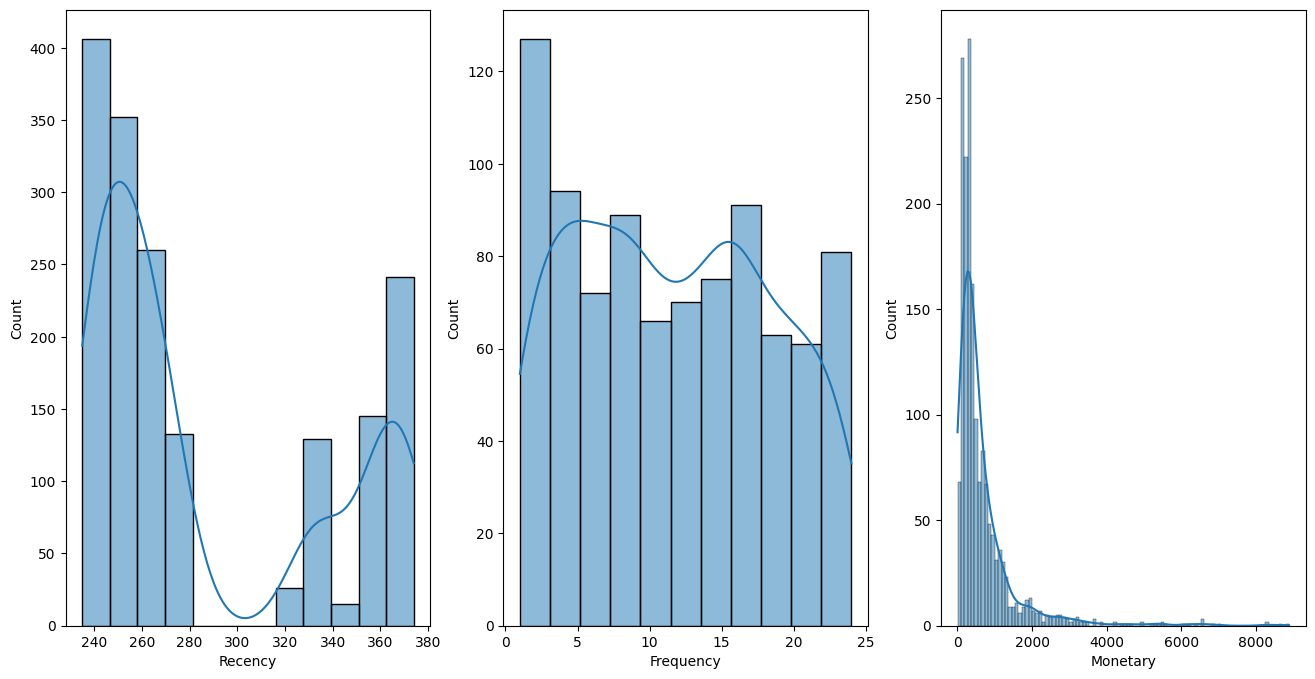

In [41]:
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
sns.histplot(rfm_scores_df['Recency'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(rfm_scores_df.query('Frequency < 25')['Frequency'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(rfm_scores_df.query('Monetary < 10000')['Monetary'], kde=True, ax=ax[2])

# Save RFM Numbers


In [ ]:
rfm_scores_df.to_csv('/content/drive/My Drive/Colab Notebooks/datasets/retail_rfm_numbers.csv', index=False)

# Calculate RFM Scores

In [42]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [43]:
# We are going to divide our customer base into 3 segments: 
#    1st segment: top 20%
#    2nd segment: 20% - 60%
#    3rd segment: bottom 40%

# Understand and calculate different quantiles

segments = [0.33, 0.66]

quantiles = rfm_scores.approxQuantile(
    ["Recency", "Frequency", "Monetary"], 
    segments,
    0)
quantiles

[[253.0, 276.0], [15.0, 37.0], [274.0, 590.0]]

In [ ]:
# salary = spark.read.csv("employee_quartile.csv", inferSchema=True, header=True)
# salary.approxQuantile("salary", [0.25, 0.5, 0.75], 0)

In [44]:
# Calculate R,F,M scores considering 3 quantiles
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
rfm_scores = (rfm_scores
    .withColumn("R_Score",
                F.when(F.col("Recency") < quantiles[0][0], F.lit(1))
                 .when(F.col("Recency") < quantiles[0][1], F.lit(2))
                 .otherwise(F.lit(3)))
    .withColumn("F_Score",
                F.when(F.col("Frequency") < quantiles[1][0], F.lit(3))
                 .when(F.col("Frequency") < quantiles[1][1], F.lit(2))
                 .otherwise(F.lit(1)))
    .withColumn("M_Score",
                F.when(F.col("Monetary") < quantiles[2][0], F.lit(3))
                 .when(F.col("Monetary") < quantiles[2][1], F.lit(2))
                 .otherwise(F.lit(1))))

# printdf(rfm_scores.filter(F.col("CustomerID").isin([12346,12747,12748,12749,12820])))
# printdf(rfm_scores)

# rfm_scores.describe().show()

In [45]:
# Aggregate RFM scores

rfm_agg_scores = (
    rfm_scores
    .withColumn("RFM_Score", F.col("R_Score") + F.col("F_Score") + F.col("M_Score"))
    .withColumn("RFM_ScoreGroup", F.concat(F.col("R_Score").cast(StringType()), F.col("F_Score").cast(StringType()), F.col("M_Score").cast(StringType())))
)

printdf(rfm_agg_scores)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_ScoreGroup
0,12346,326,1,77184.0,3,3,1,7,331
1,12747,362,15,709.0,3,2,1,6,321
2,12748,237,982,6586.0,1,1,1,3,111
3,12820,327,11,172.0,3,3,3,9,333
4,12823,255,1,459.0,2,3,2,7,232


In [46]:
df_rfm_agg_scores = rfm_agg_scores.toPandas()
df_rfm_agg_scores.shape

(1707, 9)

<Axes: xlabel='RFM_ScoreGroup', ylabel='count'>

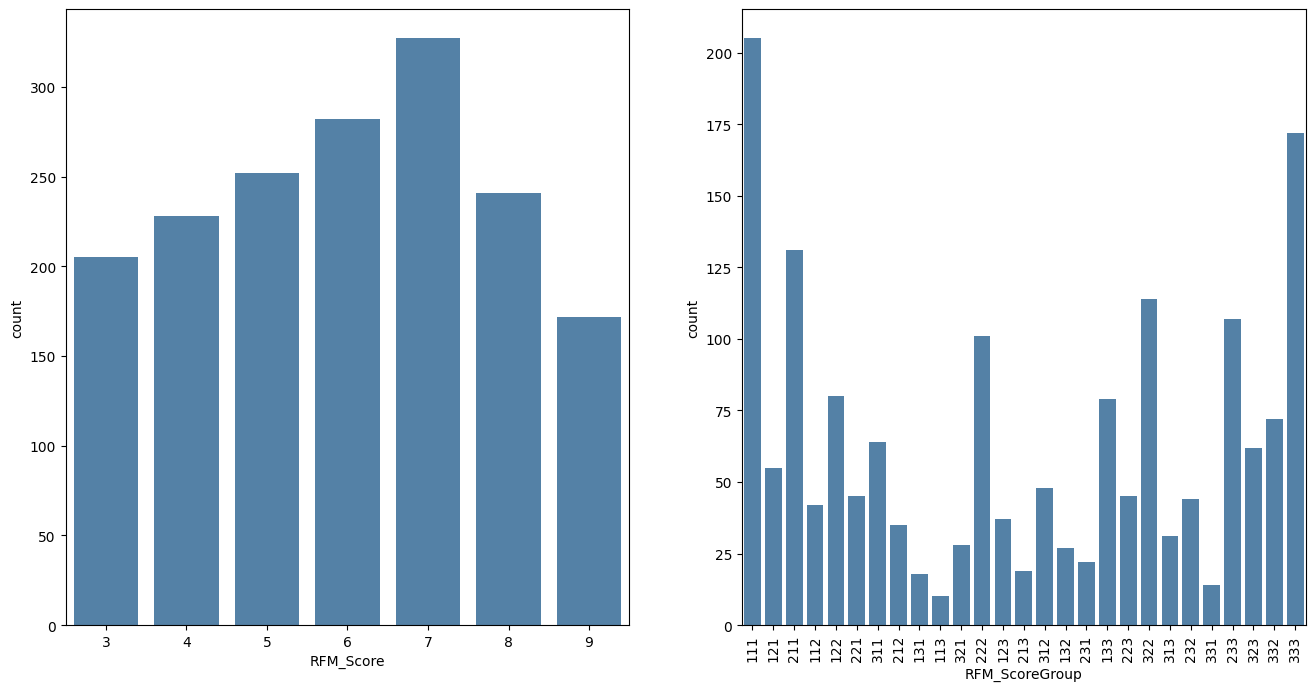

In [47]:
# Inspect RFM

df_rfm_agg_scores = df_rfm_agg_scores.sort_values(["RFM_Score"])

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plt.xticks(rotation=90)
# sns.histplot(df_rfm_agg_scores["RFMScore"], kde=True, bins=10, ax=ax[0])
sns.countplot(x="RFM_Score", data=df_rfm_agg_scores, 
              color='steelblue', ax=ax[0])
sns.countplot(x="RFM_ScoreGroup", data=df_rfm_agg_scores, 
              color='steelblue', ax=ax[1])
# sns.histplot(df_rfm_agg_scores["RFMScoreGroup"], color='steelblue', ax=ax[2])

# Segmentation 1

In [48]:
# Identify the three segments again based on RFMScore (33% in each segment)
segments = [0.33, 0.66]
quantiles = rfm_agg_scores.approxQuantile("RFM_Score", segments, 0)
quantiles

[5.0, 7.0]

In [49]:
# Assign loyalty level to each customer
loyalty_level = ['Platinum', 'Gold', 'Silver']

rfm_loyalty = (rfm_agg_scores
    .withColumn("Loyalty",
                F.when((F.col("RFM_Score") <= quantiles[0]), F.lit(loyalty_level[0]))
                 .when((F.col("RFM_Score") <= quantiles[1]), F.lit(loyalty_level[1]))
                 .otherwise(F.lit(loyalty_level[2]))))

In [50]:
printdf(rfm_loyalty)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_ScoreGroup,Loyalty
0,12346,326,1,77184.0,3,3,1,7,331,Gold
1,12747,362,15,709.0,3,2,1,6,321,Gold
2,12748,237,982,6586.0,1,1,1,3,111,Platinum
3,12820,327,11,172.0,3,3,3,9,333,Silver
4,12823,255,1,459.0,2,3,2,7,232,Gold


# inspect our loyalty segmentation

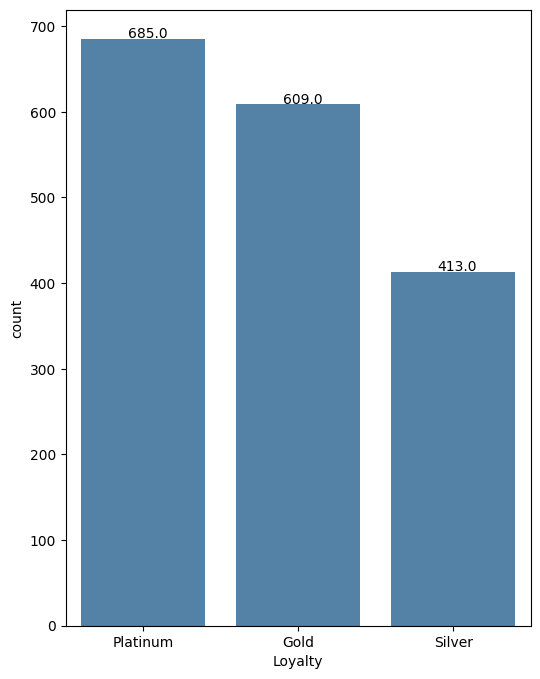

In [51]:
# inspect our loyalty segmentation

df_rfm_loyalty = rfm_loyalty.toPandas().sort_values(["RFM_ScoreGroup"])

fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="Loyalty", data=df_rfm_loyalty, color='steelblue')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))

In [52]:
df_rfm_loyalty.to_csv('/content/drive/My Drive/Colab Notebooks/datasets/retail_loyalty_rfm.csv', index=False)

In [ ]:
# Restricting the dataset (Monetary < 5000 & Frequency < 500) to best fit the chart

df_rfm_loyalty = (rfm_loyalty
    .filter(F.col("Monetary") < 5000)
    .filter(F.col("Frequency") < 500)
).toPandas()

<Axes: xlabel='Monetary', ylabel='Frequency'>

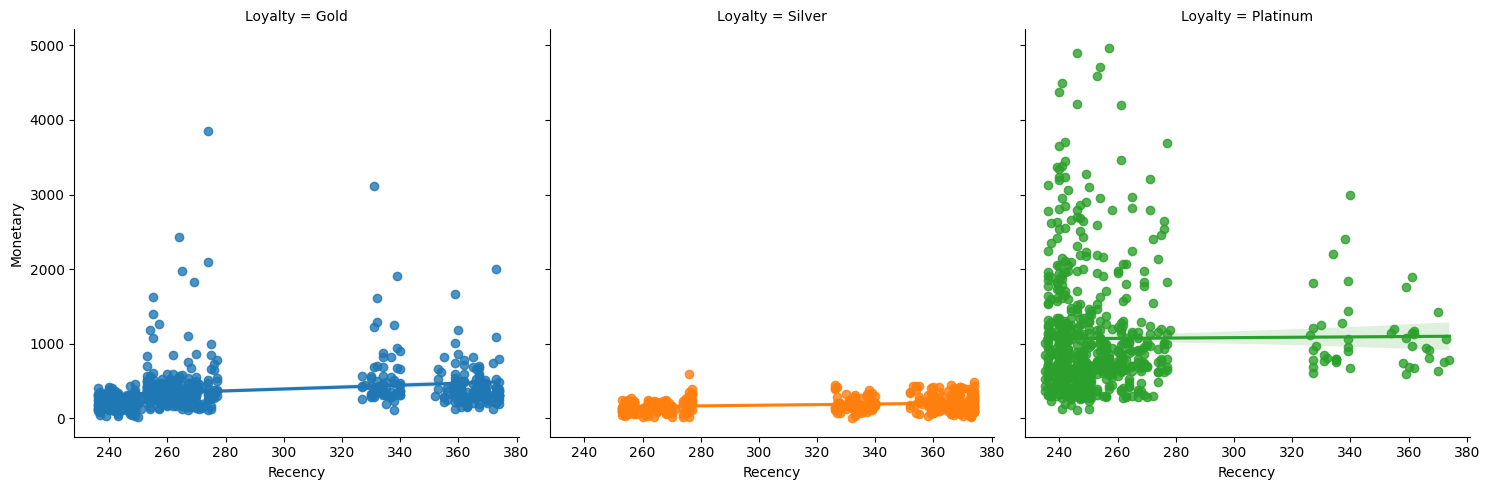

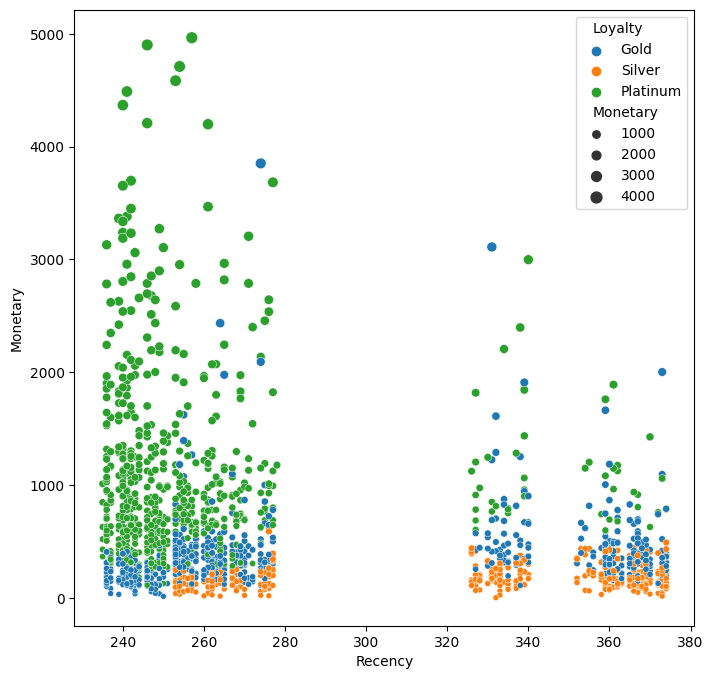

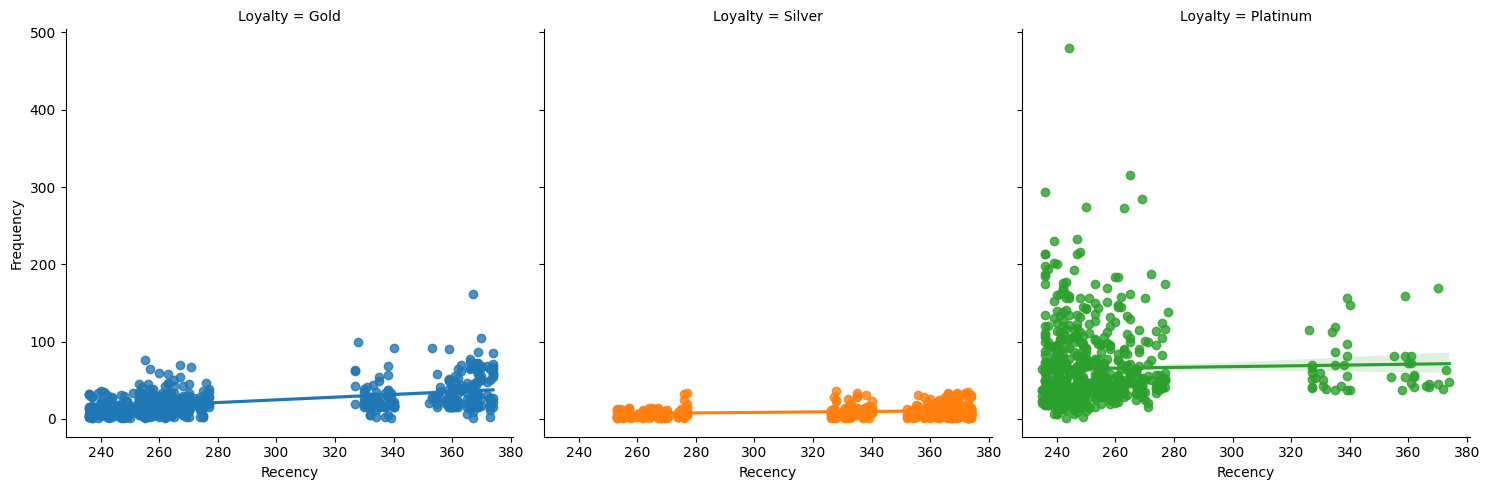

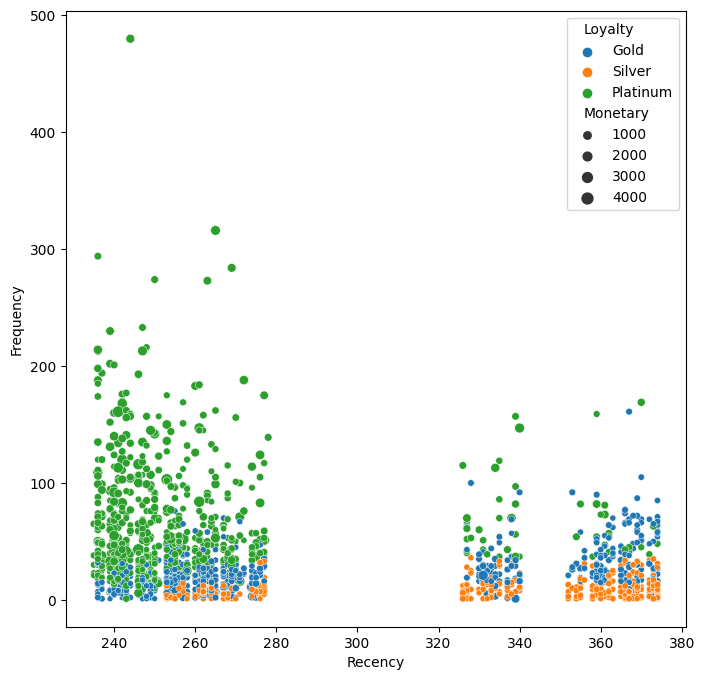

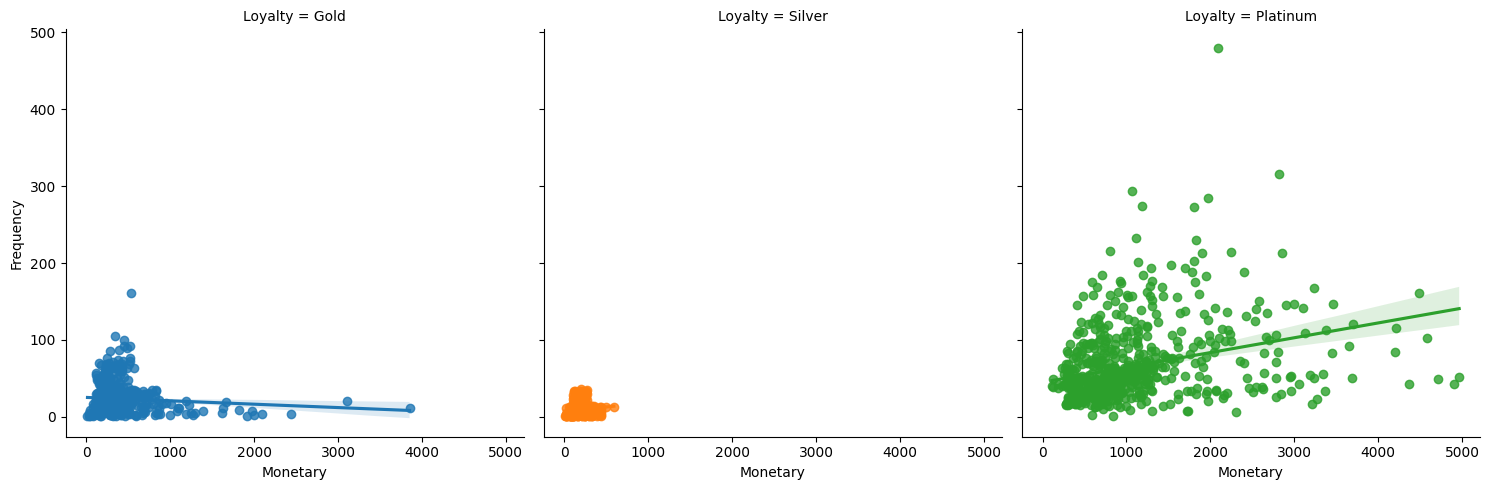

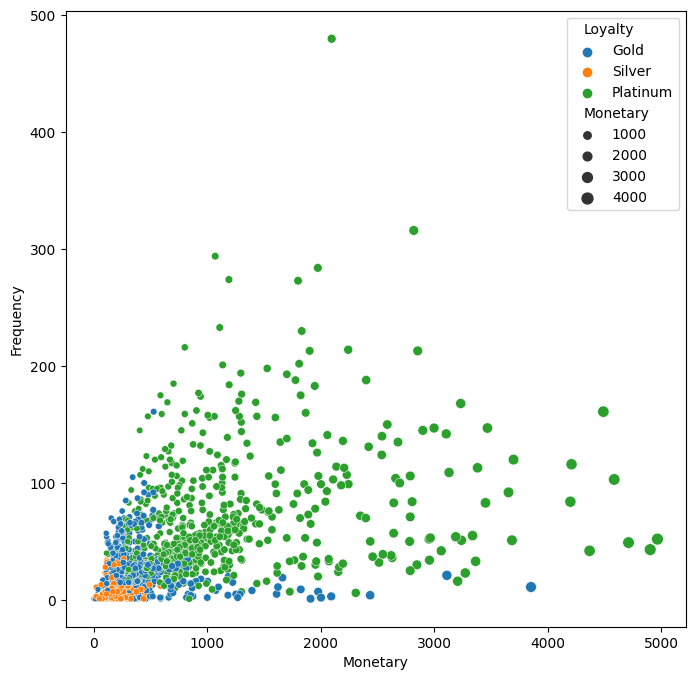

In [ ]:
# Monetary vs Recency for each segment
sns.lmplot(x='Recency', y='Monetary', data=df_rfm_loyalty, col='Loyalty', hue='Loyalty', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Monetary', data=df_rfm_loyalty, hue='Loyalty', size='Monetary')

# Frequency vs Recency for each segment
sns.lmplot(x='Recency', y='Frequency', data=df_rfm_loyalty, col='Loyalty', hue='Loyalty', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Frequency', data=df_rfm_loyalty, hue='Loyalty', size='Monetary')

# Monetary vs Frequency for each segment
sns.lmplot(x='Monetary', y='Frequency', data=df_rfm_loyalty, col='Loyalty', hue='Loyalty', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Monetary', y='Frequency', data=df_rfm_loyalty, hue='Loyalty', size='Monetary')

# Segmentation 2

In [ ]:
# Assign loyalty level to each customer

# Champion: Loyal Customers, they are the champions with highest score of RFM.
# Potential: Customers who have the most potential to become the Champions.
#            They recently shopped and their purchases frequency is high as well. 
#            Moreover, the amount they spent is quite good.
# Require Attention: Customers who used to shop a lot with high money. but they did not purchase recently. 
# Lost: Customers who haven't paid a visit to the store for a long time.


segments = {
    'Champion':['111'], 
    'Potential':['112','113','121','131','123','122','133','132'], 
    'Need Attention':['211','221','231','232','213','212','233','223','222'],
    'Lost':['312','321','331','311','333','332','323','322','313']
}

rfm_segment = (rfm_agg_scores
    .withColumn("Segment",
                F.when((F.col("RFM_ScoreGroup").isin(segments['Champion'])), F.lit('Champion'))
                 .when((F.col("RFM_ScoreGroup").isin(segments['Potential'])), F.lit('Potential'))
                 .when((F.col("RFM_ScoreGroup").isin(segments['Need Attention'])), F.lit('Need Attention'))
                 .otherwise(F.lit('Lost'))))

In [ ]:
# printdf(rfm_loyalty.filter(F.col("CustomerID").isin([12346,12747,12748,12749,12820])))
# printdf(rfm_loyalty.filter(F.col("RFM_ScoreGroup") == "111"), 10)
printdf(rfm_segment)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_ScoreGroup,Segment
0,12346,326,1,77184.0,3,3,1,7,331,Lost
1,12747,362,15,709.0,3,2,1,6,321,Lost
2,12748,237,982,6586.0,1,1,1,3,111,Champion
3,12820,327,11,172.0,3,3,3,9,333,Lost
4,12823,255,1,459.0,2,3,2,7,232,Need Attention


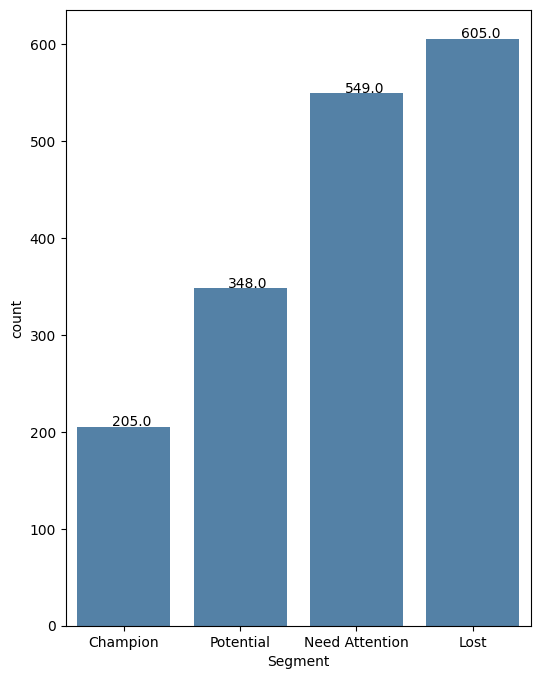

In [ ]:
df_rfm_segment = rfm_segment.toPandas().sort_values(["RFM_ScoreGroup"])

fig, ax = plt.subplots(1, 1, figsize=(6, 8))

# sns.histplot(df_rfm_loyalty["Loyalty"], color='steelblue', shrink=.8)
sns.countplot(x="Segment", data=df_rfm_segment, color='steelblue')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))

In [ ]:
# rfm_loyalty.write.format("csv").save('retail_loyalty_rfm_spark.csv')
# df_rfm_segment.to_csv('retail_rfm_segment.csv', index=False)

# Visualize

In [ ]:
# Restricting the dataset (Monetary < 5000 & Frequency < 500) to optimize the chart

df_rfm_segment = (rfm_segment
    .filter(F.col("Monetary") < 5000)
    .filter(F.col("Frequency") < 500)
).toPandas()

<Axes: xlabel='Monetary', ylabel='Frequency'>

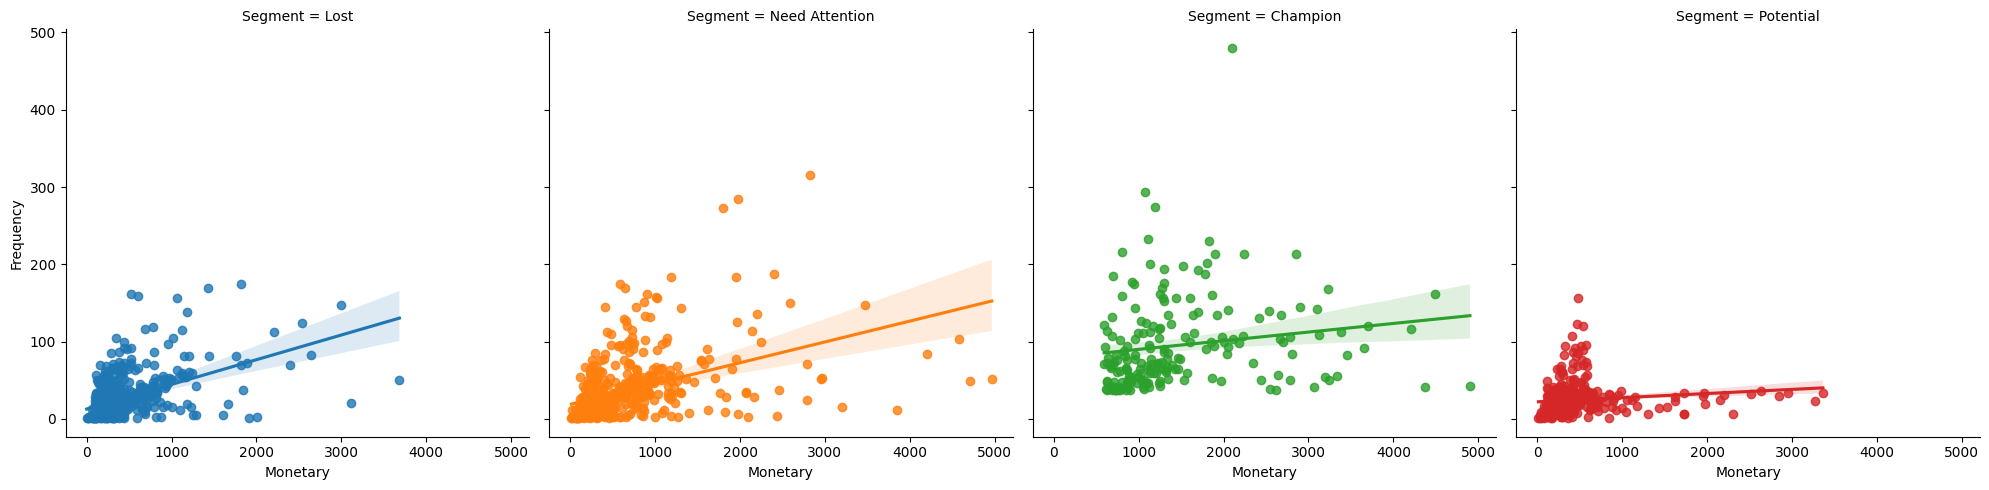

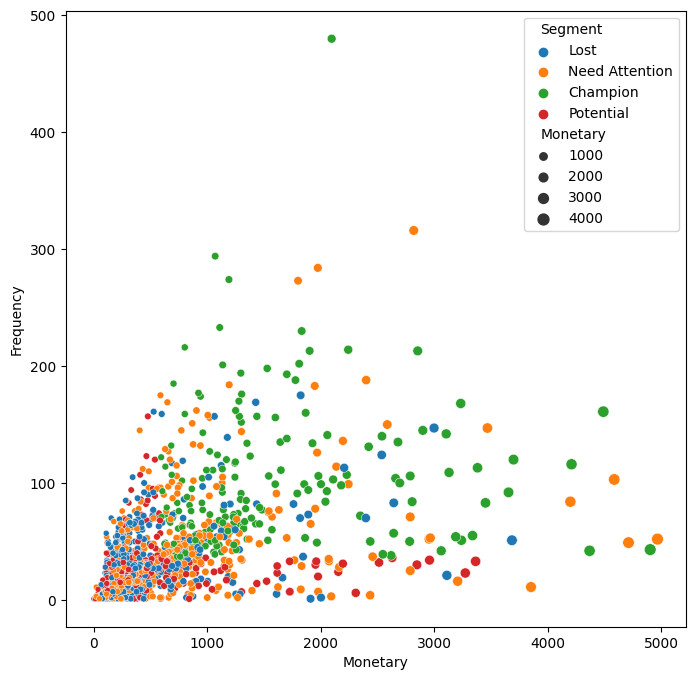

In [ ]:
# Monetary vs Frequency for each segment
sns.lmplot(x='Monetary', y='Frequency', data=df_rfm_segment, col='Segment', hue='Segment', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Monetary', y='Frequency', data=df_rfm_segment, hue='Segment', size='Monetary')

<Axes: xlabel='Recency', ylabel='Monetary'>

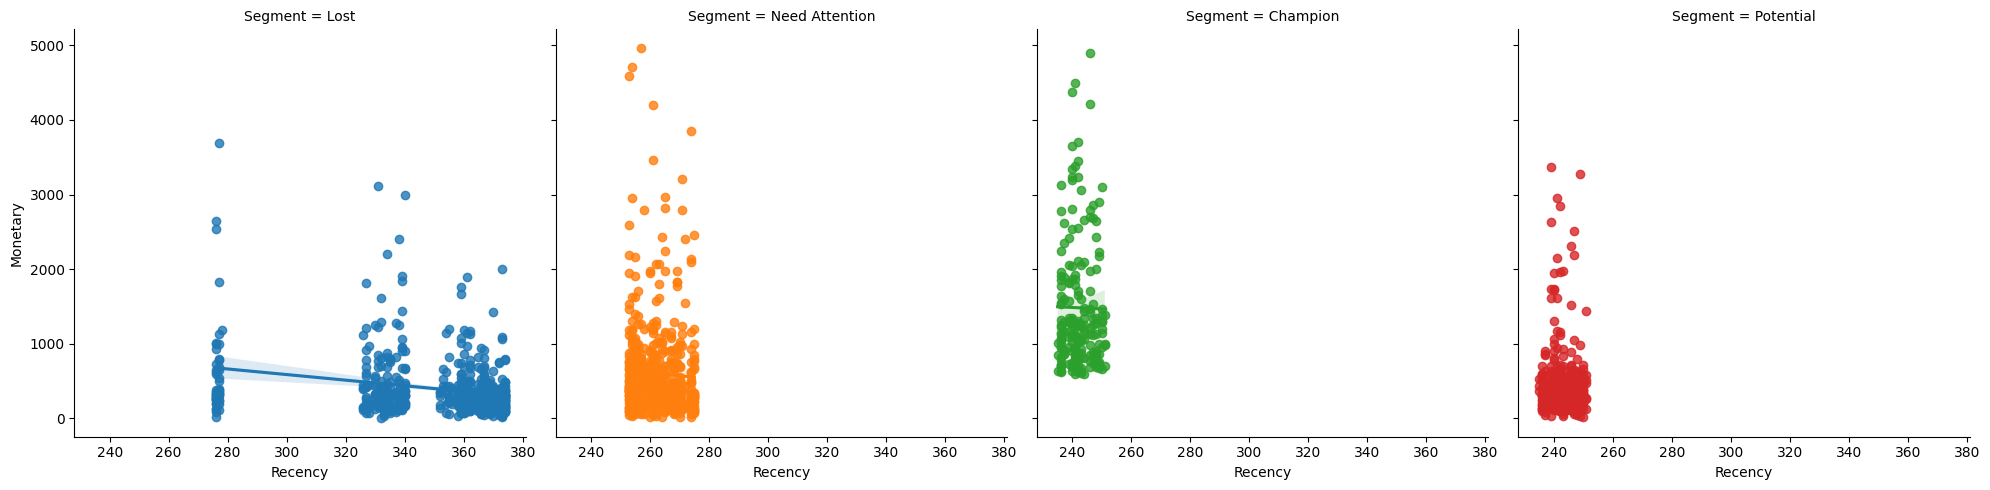

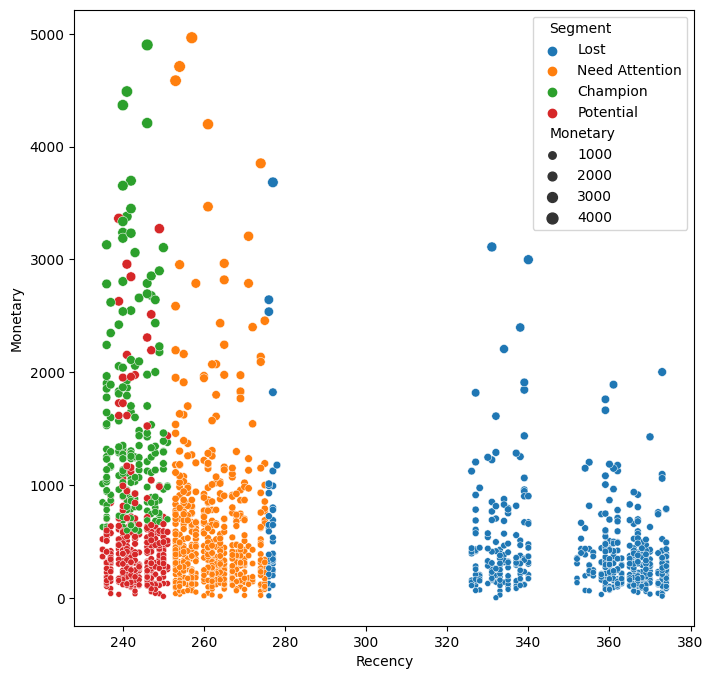

In [ ]:
# Monetary vs Recency for each segment
sns.lmplot(x='Recency', y='Monetary', data=df_rfm_segment, col='Segment', hue='Segment', fit_reg=True)

# Monetary vs Recency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Monetary', data=df_rfm_segment, hue='Segment', size='Monetary')

<Axes: xlabel='Recency', ylabel='Frequency'>

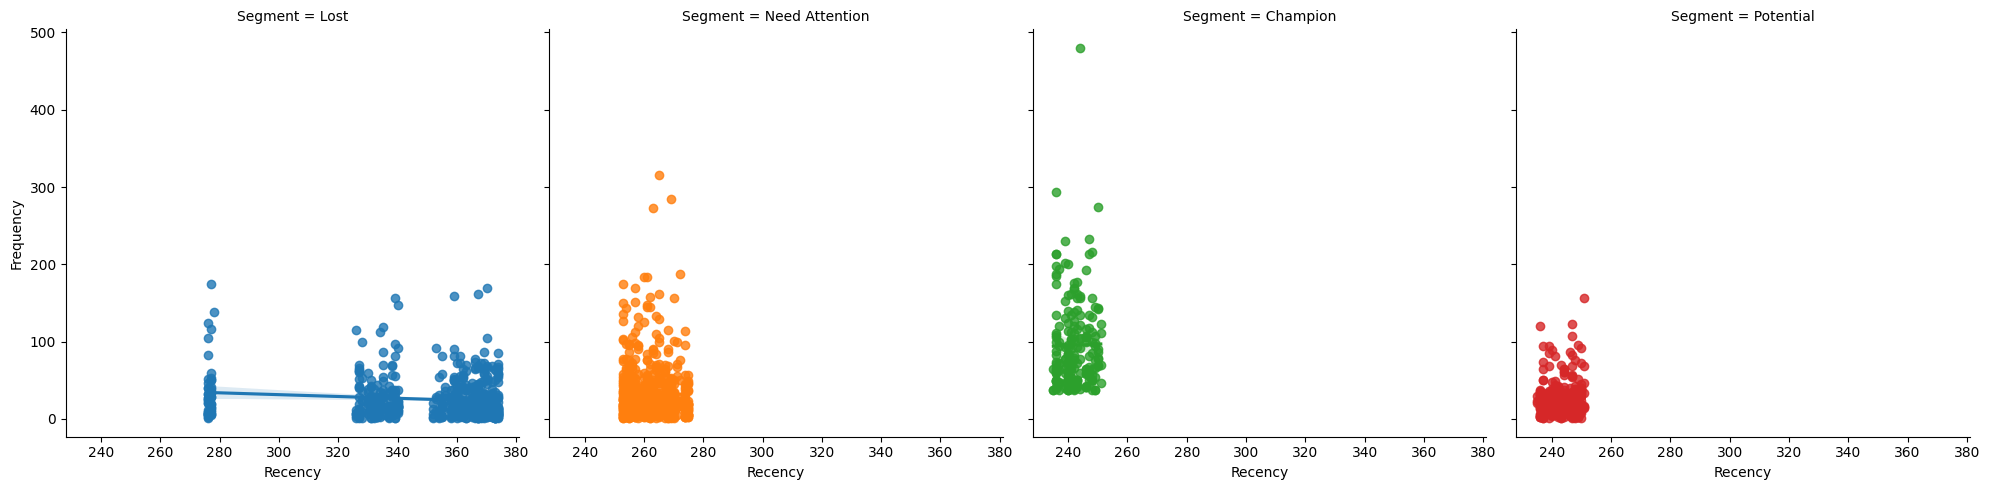

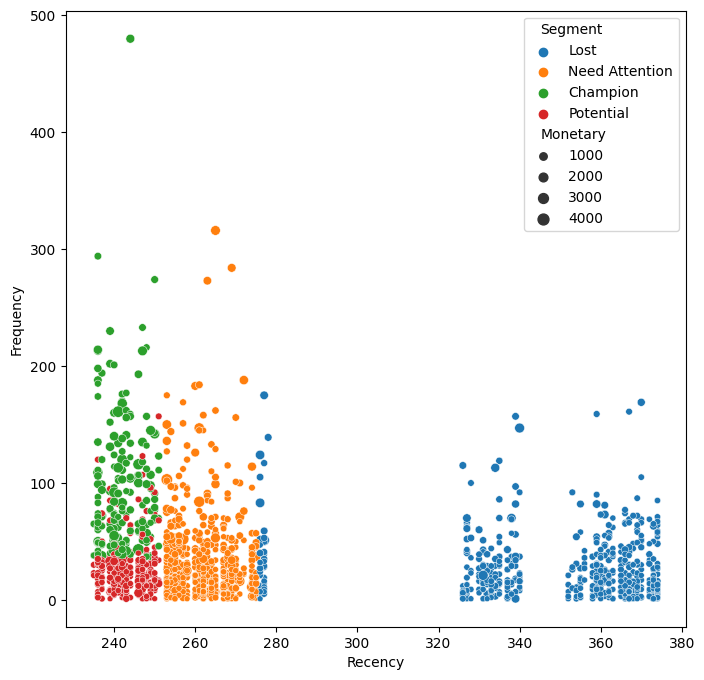

In [ ]:
# Frequency vs Recency for each segment
sns.lmplot(x='Recency', y='Frequency', data=df_rfm_segment, col='Segment', hue='Segment', fit_reg=True)

# Monetary vs Recency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Frequency', data=df_rfm_segment, hue='Segment', size='Monetary')

In [ ]:

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# colors = {'Champion':'green', 'Potential':'blue', 'Need Attention':'orange', 'Lost':'red'}

# ax.scatter(xs=df_rfm_segment.Frequency, 
#            ys=df_rfm_segment.Recency, 
#            zs=df_rfm_segment.Monetary, 
#            c=[colors[x] for x in df_rfm_segment.Segment])